# Changing chirp range

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sigtools
import os

def get_chirp_plot(folder):
    files = [f for f in os.listdir(folder)]
    initial = pd.read_pickle(f'{folder}/initial.pkl')
    qmeter = pd.read_csv(f'{folder}/' + [f for f in files if f.startswith('qmeter') and f.endswith('.csv')][0]).drop_duplicates()[1:]

    scope0 = []
    scope0_files = [f'{folder}/{f}' for f in files if f.startswith('scope_0') and f.endswith('.pkl')]
    scope0_files.sort(key = lambda f: f.split('T')[1])
    for file in scope0_files[1:]:
        scope0.append(pd.read_pickle(file))

    scope1 = []
    scope1_files = [f'{folder}/{f}' for f in files if f.startswith('scope_1') and f.endswith('.pkl')]
    scope1_files.sort(key = lambda f: f.split('T')[1])
    for file in scope1_files[1:]:
        scope1.append(pd.read_pickle(file))
    #qmeter.plot(x='variable', y='amplitude', style='x')

    #fig, ax = plt.subplots(len(scope0), 1,figsize=(7, 15))
    freq_start = []
    freq_stop = []
    for i, (param, scope) in enumerate(list(zip(initial['param_space'], scope0))):
        data = scope['data']
        limit = (1000, 65500)
        time = data['time'][limit[0]:limit[1]]
        value = data['value'][limit[0]:limit[1]]

        #ax[i].plot(time, value, label='ch1')

        yf = np.fft.rfft(value)
        xf = np.fft.rfftfreq(len(time))
        #ax[i].plot(xf, np.abs(yf), label='ch1 fft')
        #ax[i].set_xlim(0, 0.004)

        peaks, properties = sigtools.find_peaks(np.abs(yf), prominence = 1e7)
        # plot all of the peaks found
        #for peak in peaks:
        #    ax[i].plot(xf[peak], np.abs(yf[peak]), 'x', label='peaks')

        frequency_range = [round(xf[peak], 4) for peak in peaks]
        frequency_start = frequency_range[0]
        frequency_end = frequency_range[-1]
        freq_start.append(frequency_start)
        freq_stop.append(frequency_end)

        #print(f"chirp from {initial['qmeter_settings']['chirp_h_start'][1]} to {round(param, 2)} \tfreq from {frequency_start} to {frequency_end}")
    return freq_start, freq_stop, initial['qmeter_settings']['chirp_h_start'][1], initial['param_space']
        

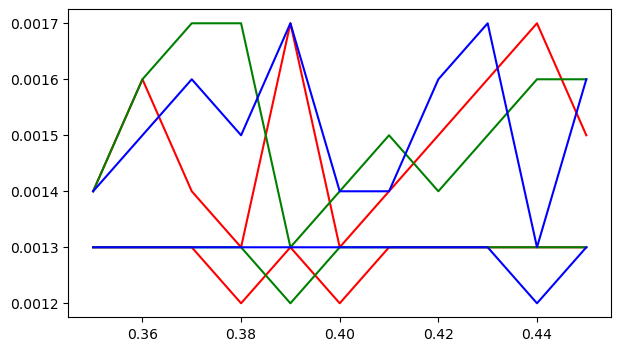

In [27]:
# From above

zero_1 = 'results/2022-11-17T15:30:03'
zero_2 = 'results/2022-11-17T15:38:51'
zero_3 = 'results/2022-11-17T16:07:11'

stop1_initial, stop1_final, start1, param_space1 = get_chirp_plot(zero_1)
stop2_initial, stop2_final, start2, param_space2 = get_chirp_plot(zero_2)
stop3_initial, stop3_final, start3, param_space3 = get_chirp_plot(zero_3)

fig, ax = plt.subplots(1, 1,figsize=(7, 4))
ax.plot(param_space1, stop1_initial, 'r', label='gain=0.1')
ax.plot(param_space1, stop1_final, 'r', label='gain=0.1')
ax.plot(param_space2, stop2_initial, 'g', label='gain=0.2')
ax.plot(param_space2, stop2_final, 'g', label='gain=0.2')
ax.plot(param_space3, stop3_initial, 'b', label='gain=0.3')
ax.plot(param_space3, stop3_final, 'b', label='gain=0.3')

# Changing chirp interval

In [310]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sigtools

def freq_analysis(folder):
    
    results_dir = 'results/' + folder
    files = os.listdir(results_dir)
    initial = pd.read_pickle(f'{results_dir}/initial.pkl')
    print("="*30, f"\nknob: {initial['knob']}\nparameters: {initial['param_space']}\n", "="*30)

    signal_files = [f for f in files if f.startswith('signal') and f.endswith('.pkl')][1:]
    signal_files.sort(key = lambda f: f.split('T')[1])
    signal = []
    for file in signal_files:
        signal.append(pd.read_pickle(f'{results_dir}/{file}'))
    sampling_period = 1e-4 #seconds
    fig, ax = plt.subplots(len(signal), 2, figsize=(10, 9), tight_layout=True, sharex='col')
    fig.suptitle(f"changing {initial['knob']} from {round(initial['param_space'][0], 3)} to {round(initial['param_space'][-1], 3)}")

    for i, (s, param) in enumerate(list(zip(signal, initial['param_space']))):
        param_seconds = param * 0.001
        ax[i][0].plot(s.values[0])
        yf = np.fft.rfft(s.values[0])
        xf = np.fft.rfftfreq(len(s.values[0]), (sampling_period))

        if initial['knob'] == 'interval':
            ax[i][1].vlines(1/param_seconds, 0, np.max(np.abs(yf)), colors='r', linestyles='dashed', label=f'{param} ms')
            m = int(np.floor(np.log2((np.max(xf)/(1/param_seconds)))))
            for n in [2**h for h in range(2, m+1)]:
                ax[i][1].vlines(n/param_seconds, 0, np.max(np.abs(yf)), colors='grey', linestyles='dotted', label=f'{param} ms')
        else:
            interval_seconds = initial['qmeter_settings']['interval'][1] * 0.001
            ax[i][1].vlines(1/interval_seconds, 0, np.max(np.abs(yf)), colors='r', linestyles='dashed', label=f'{initial["qmeter_settings"]["interval"][1]} ms')

        ax[i][1].plot(xf, np.abs(yf))
        
        # find fft peaks
        peaks, properties = sigtools.find_peaks(np.abs(yf), width = 0)
        
    #xf = np.fft.rfftfreq(len(time))

knob: chirp_h_stop
parameters: [0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42 0.43 0.44 0.45]


/opt/homebrew/Caskroom/miniconda/base/envs/cern/lib/python3.10/site-packages/numpy/ma/core.py:3377: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/opt/homebrew/Caskroom/miniconda/base/envs/cern/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


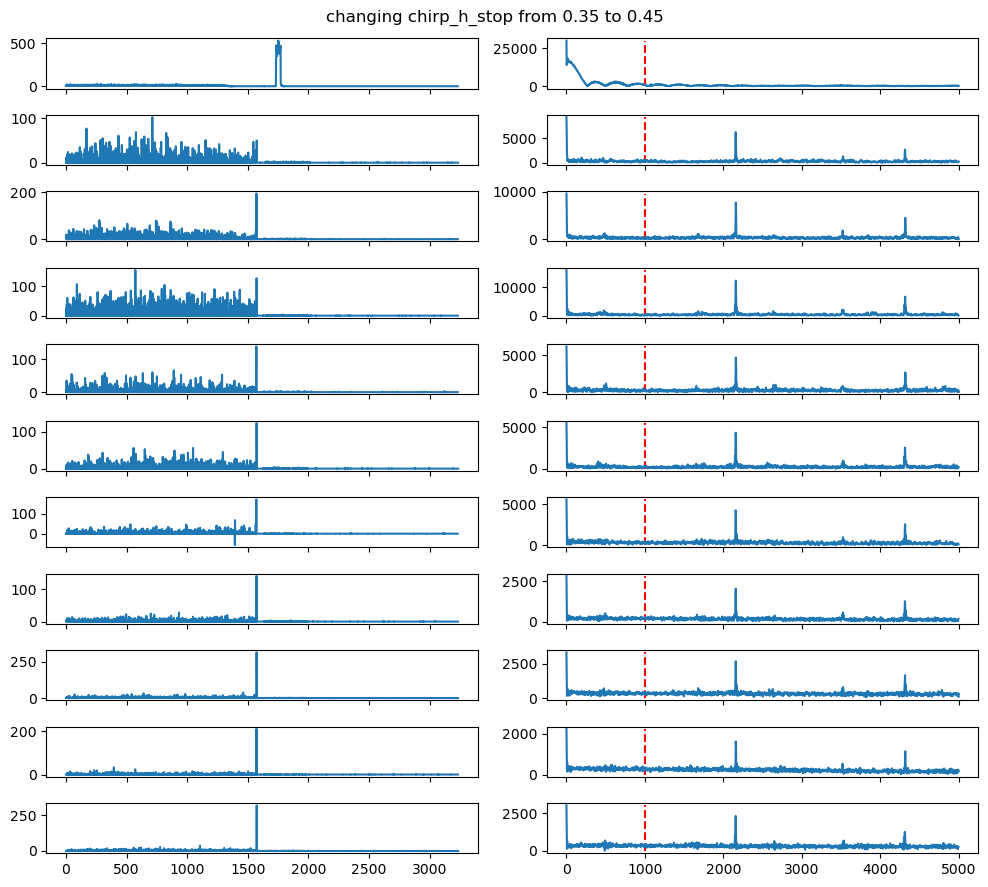

In [260]:
freq_analysis('2022-11-17T16:07:11')

knob: n_turns
parameters: [256, 512, 1024, 2048, 4096, 8192, 16384]


/opt/homebrew/Caskroom/miniconda/base/envs/cern/lib/python3.10/site-packages/numpy/ma/core.py:3377: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/opt/homebrew/Caskroom/miniconda/base/envs/cern/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


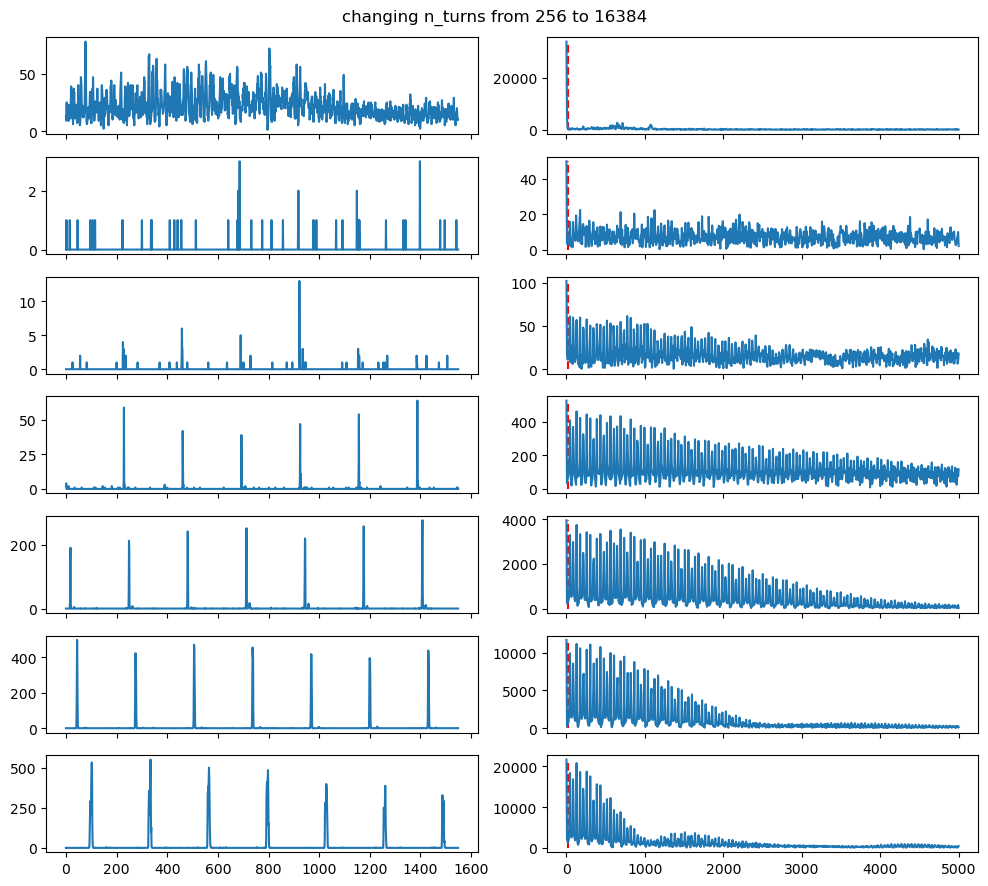

In [269]:
freq_analysis('2022-11-17T14:29:38')

knob: ex_h_amplitude
parameters: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


/opt/homebrew/Caskroom/miniconda/base/envs/cern/lib/python3.10/site-packages/numpy/ma/core.py:3377: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/opt/homebrew/Caskroom/miniconda/base/envs/cern/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


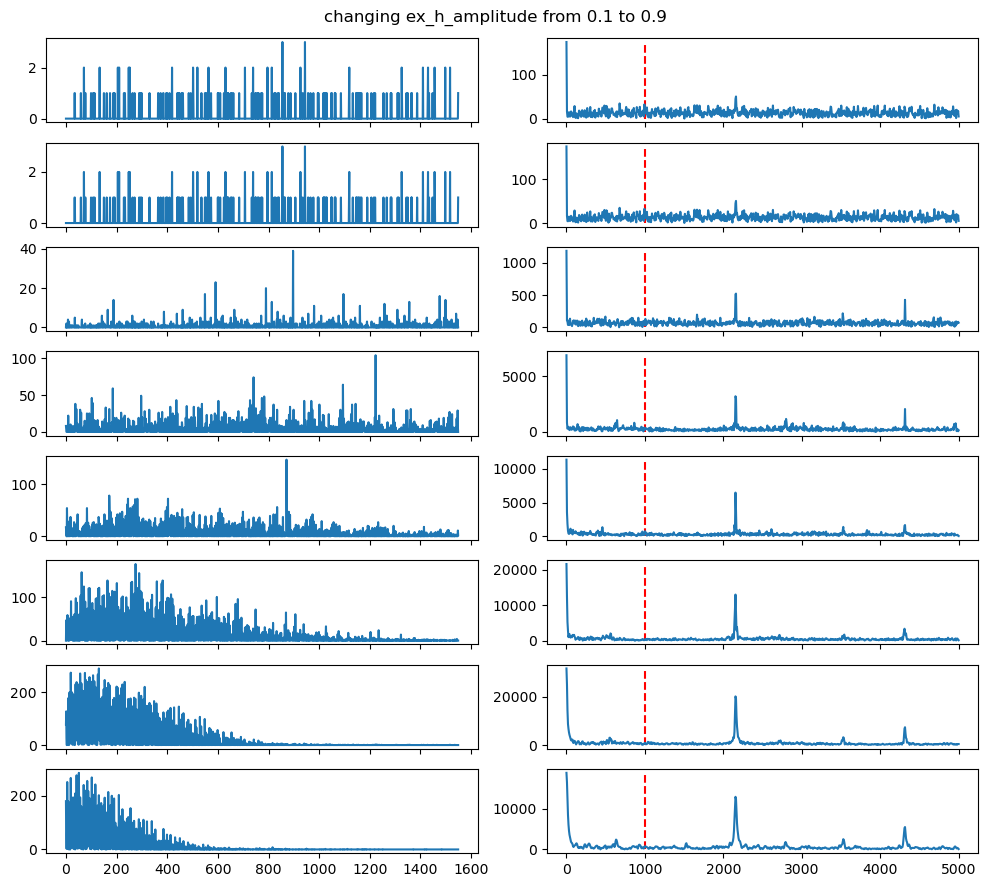

In [271]:
freq_analysis('2022-11-17T14:58:53')

knob: interval
parameters: [ 1  6 11 16 21 26 31 36 41 46]


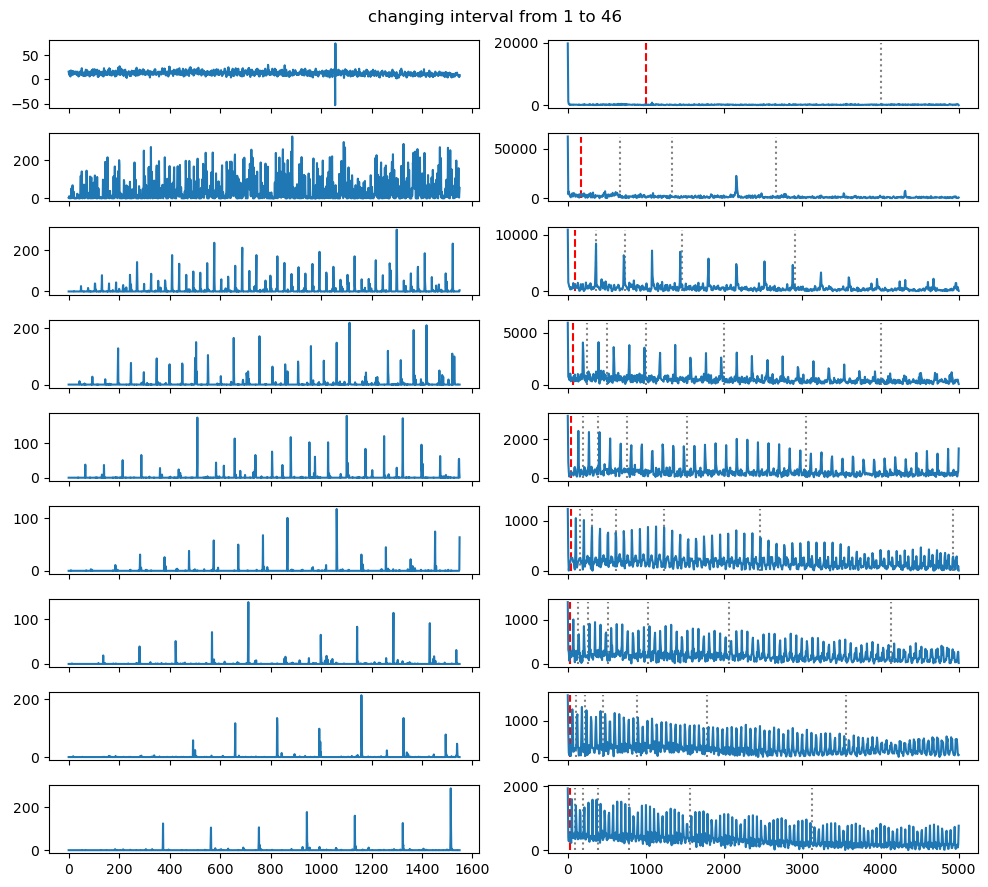

In [311]:
freq_analysis('2022-11-16T15:52:43.687625')

knob: interval
parameters: [1 2 3 4 5 6 7 8 9]


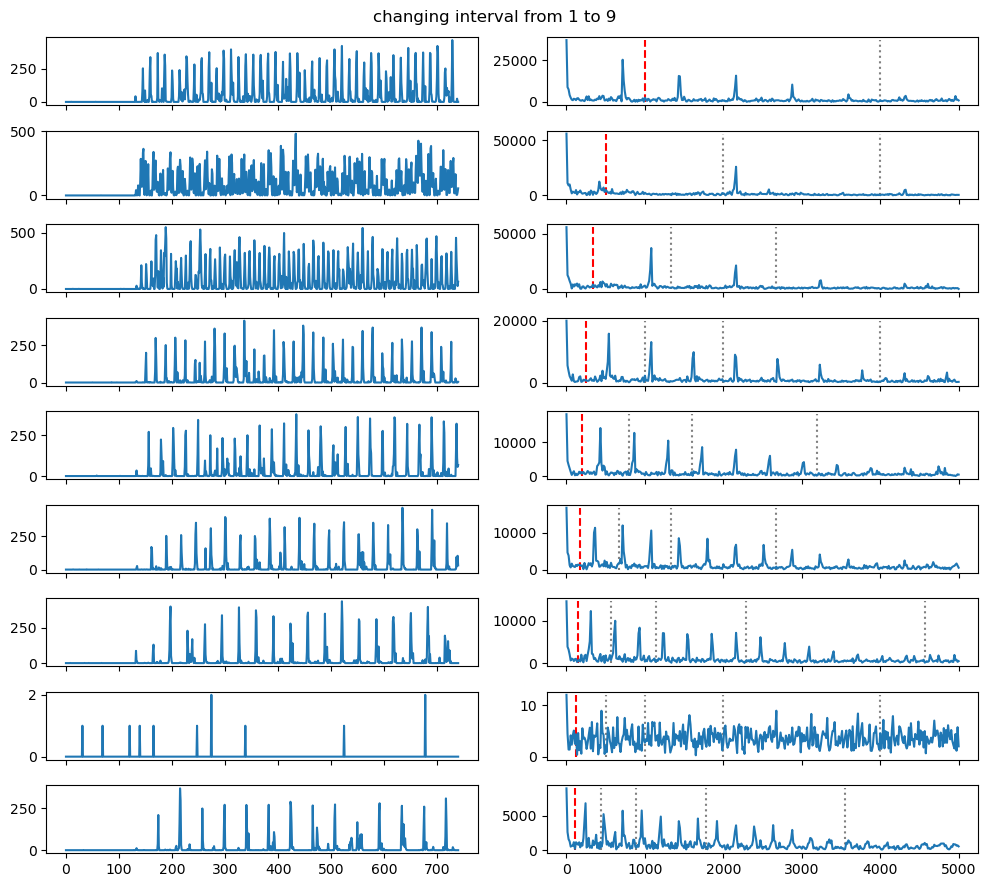

In [313]:
freq_analysis('2022-11-16T14:05:01.560634')

# OASIS Scope

In [217]:
import jpype

jpype.startJVM(jpype.getDefaultJVMPath())

In [218]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sigtools
import os

- When can i go with tom and gert
- 